# Histopathologic Cancer Detection

In this project we explore using a CNN to identify metastatic cancer. This is a binary classification task.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
from PIL import Image
import cv2
import albumentations as A
import os
path = os.getcwd()
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, activations
import albumentations as A
import h5py
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense
from tensorflow.keras.regularizers import l2
import pickle

np.random.seed(42)
batch_size=32

C:\Users\jmlam\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
train_labels = pd.read_csv(path+"\\histopathologic-cancer-detection\\train_labels.csv")
test_images_path = path+"\\histopathologic-cancer-detection\\test\\"
train_images_path = path+"\\histopathologic-cancer-detection\\train\\"

labels = train_labels["label"]

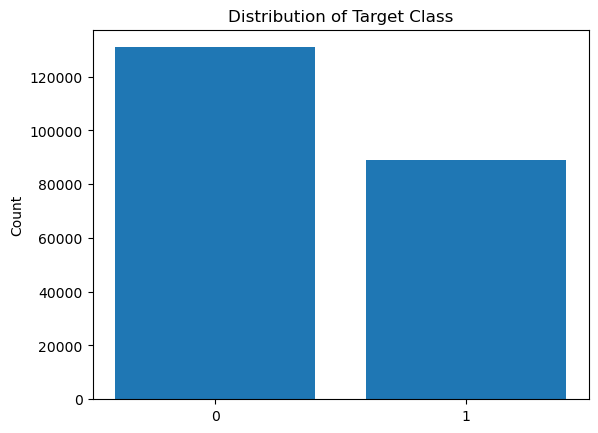

In [4]:
# Evaluating for target class balance/imbalance
plt.bar(x=train_labels["label"].value_counts().index,height=train_labels["label"].value_counts().values)
plt.xticks([0,1])
plt.title("Distribution of Target Class")
plt.ylabel("Count");

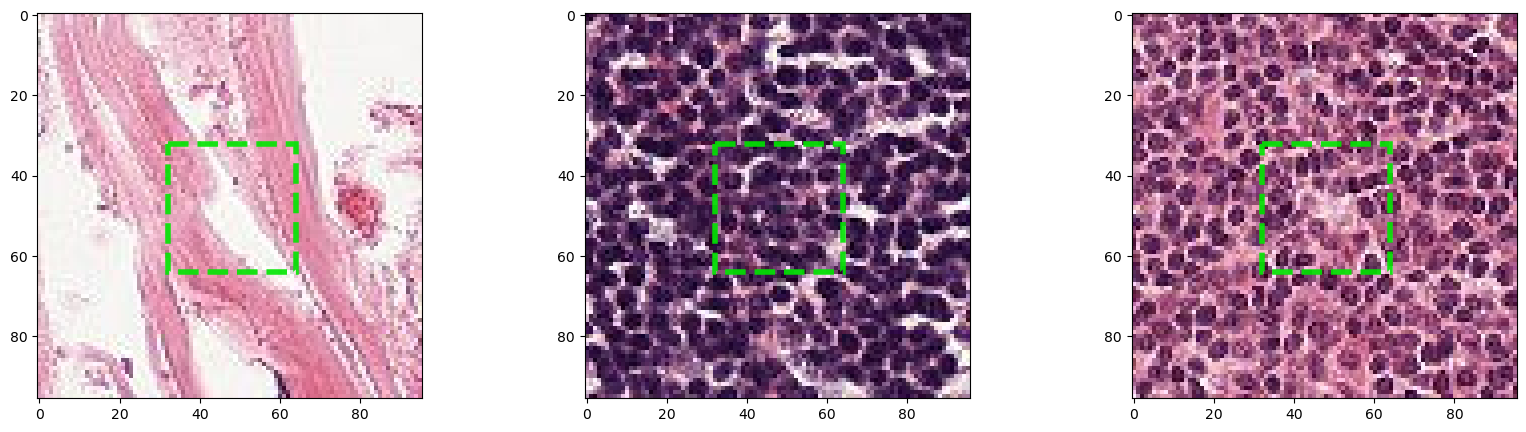

In [5]:
# Sample Images of Negative Cases
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, idx in enumerate(train_labels[train_labels['label'] == 0].sample(3)["id"]):
    pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                 fc=(0.0, 0.0, 0.0, 0.0), 
                 ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
    ax[i].add_patch(pf)
    ax[i].imshow(Image.open(train_images_path+idx+".tif"))

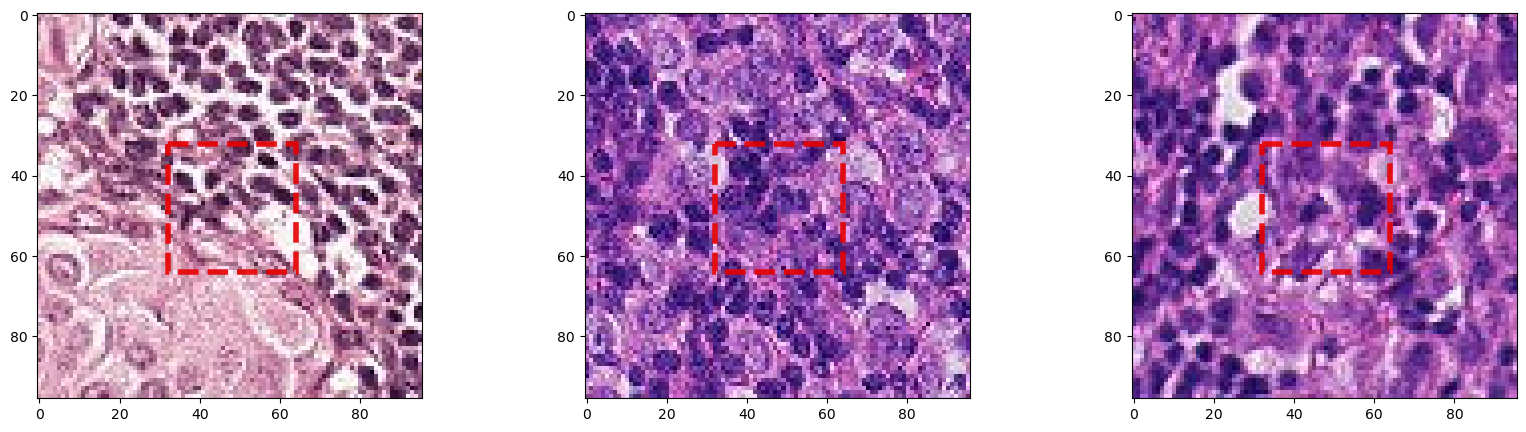

In [6]:
# Sample Images of Positive Cases
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, idx in enumerate(train_labels[train_labels['label'] == 1].sample(3)["id"]):
    pt = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                 fc=(0.0, 0.0, 0.0, 0.0), 
                 ec=(0.9, 0.0, 0.0 ,0.9), lw=4, linestyle='--')
    ax[i].add_patch(pt)
    ax[i].imshow(Image.open(train_images_path+idx+".tif"))


### Analysis:
* Target class is fairly balanced, images look cool (y)

In [7]:
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image)

In [8]:
test_images_path = path+"\\histopathologic-cancer-detection\\test\\"


In [9]:
sample_submission = pd.read_csv(path+"\\histopathologic-cancer-detection\\sample_submission.csv")
len(sample_submission)

57458

In [10]:
test_images_paths = []
for i, idx in enumerate(sample_submission["id"]):
    test_images_paths.append(test_images_path+idx+".tif")

In [11]:
image_paths = []
for i, idx in enumerate(train_labels["id"]):
    image_paths.append(train_images_path+idx+".tif")

In [12]:
# %%time

# import numpy as np
# import cv2
# import os

# def load_image(image_path):
#     # Load an image and normalize its pixel values to [0, 1]
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
#     return image

# def compute_mean_std(image_paths):
#     # Initialize sums and counters
#     sum_means = np.zeros(3)
#     sum_variances = np.zeros(3)
#     count = 0

#     for path in image_paths:
#         image = load_image(path)
#         sum_means += image.mean(axis=(0, 1))
#         sum_variances += image.var(axis=(0, 1))
#         count += 1

#     # Compute the mean and std dev
#     mean = sum_means / count
#     std_dev = np.sqrt(sum_variances / count)

#     return mean, std_dev

# # Assuming you have a list of image paths
# mean, std_dev = compute_mean_std(image_paths)

# print("Mean: ", mean)
# print("Standard Deviation: ", std_dev)


In [13]:
# with open("means.pkl", "wb") as f:
#     pickle.dump(mean, f)
    
# with open("std_dev.pkl", "wb") as f:
#     pickle.dump(std_dev, f)    
    
with open("means.pkl", "rb") as f:
    mean=pickle.load(f)
    
with open("std_dev.pkl", "rb") as f:
    std=pickle.load(f)

In [14]:
def get_training_augmentation(mean,std):
    train_transform = [
        # Geometric transformations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=90),
        
        # Color variations
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)
        ], p=0.5),
        
        # Blur and noise
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5), p=0.5),
            A.GaussNoise(var_limit=(10, 50), p=0.5)
        ], p=0.5),
        
        # Central Crop
#         A.Crop(x_min=32, y_min=32, x_max=64, y_max=64, always_apply=True),
        
        # Normalization
        A.Normalize(mean=mean, std=std, always_apply=True)
    ]
    return A.Compose(train_transform)

def data_generator(image_paths, labels, batch_size, augmentation, is_train=False):
    num_samples = len(image_paths)
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            batch_images = []
            for img_path in batch_paths:
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        if is_train:
                            img = augmentation(image=img)['image']

                        center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
                        start_x, start_y = center_x - 16, center_y - 16
                        img = img[start_y:start_y + 32, start_x:start_x + 32]
                        
                        img = img / 255.0  # Normalize images
                        batch_images.append(img)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

            if len(batch_images) > 0:
                yield np.array(batch_images), np.array(batch_labels[:len(batch_images)])




def create_simple_model(input_shape, activation):
    model = models.Sequential()
    
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation=activation, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def create_complex_model(input_shape, activation):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), activation=activation, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.35))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def create_dense_model(input_shape, activation):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation=activation, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.Dense(256, activation=activation, kernel_regularizer=l2(1e-4)))  # Additional dense layer
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


def scheduler(epoch, lr):
    if epoch < 10:
        return initial_learning_rate 
    else:
        return lr * tf.math.exp(-0.02)  # Slower decay rate

In [15]:
# batch_size=32
# initial_learning_rate=0.001
# num_epochs=25
# input_shape = (32, 32, 3)
# activation=LeakyReLU(alpha=0.01)
# stride=(2, 2)
# pool_size = (2, 2)
# momentum=0.99
# kernel_size=(3, 3)
# target_shape = (32,32)

In [16]:
# add padding=same

In [17]:
# %%time

# from sklearn.model_selection import train_test_split, KFold 

# # Initialize models with the same input shape and activation
# simple_model = create_simple_model(input_shape, activation)
# complex_model = create_complex_model(input_shape, activation)
# dense_model = create_dense_model(input_shape, activation)

# # Compile models
# simple_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy', AUC()])
# complex_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy', AUC()])
# dense_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy', AUC()])

# # Expand model list
# model_list = [simple_model, complex_model, dense_model]

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Change to 'val_loss' or another metric if desired
#     patience=10,        # Number of epochs with no improvement
#     mode='min',        # In 'max' mode, training will stop when the quantity monitored has stopped increasing
#     verbose=1,
#     restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
# )

# schedule = LearningRateScheduler(scheduler)
# callbacks = [schedule, early_stopping]

# results = {}

# n_splits = 3
# kf = KFold(n_splits=n_splits)

# for modelx in model_list:
#     model_results = []  # Store results for each model separately
#     for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
#         print(f"Training on fold {fold + 1}/{n_splits}...")

#         # Data splitting
#         X_train, X_val = np.array(image_paths)[train_idx], np.array(image_paths)[val_idx]
#         y_train, y_val = np.array(train_labels["label"])[train_idx], np.array(train_labels["label"])[val_idx]
        
#         augmentation = get_training_augmentation(mean, std)
#         train_gen = data_generator(X_train, y_train, batch_size=batch_size, augmentation=augmentation)
#         val_gen = data_generator(X_val, y_val, batch_size=batch_size, augmentation=augmentation)

#         # Model training
#         history = modelx.fit(
#             train_gen,
#             steps_per_epoch=len(X_train) // batch_size,
#             epochs=num_epochs,
#             validation_data=val_gen,
#             validation_steps=len(X_val) // batch_size,
#             callbacks=[schedule, early_stopping],  # Add callbacks as needed
#             verbose=1
#         )

#         # Model evaluation
#         val_loss, val_acc, val_auc = modelx.evaluate(val_gen, steps=len(X_val) // batch_size)
#         model_results.append((history, val_loss, val_acc, val_auc))

#     # Average performance calculation
#     average_auc = np.mean([auc for _, _, _, auc in model_results])
#     print(f"{modelx.name} Average Validation AUC: {average_auc}")
#     results[modelx.name] = model_results  # Store results for this model


### Predictions with best model

In [18]:
# def test_data_generator(image_paths, batch_size):
#     num_samples = len(image_paths)
#     # Calculate number of batches needed, including the last smaller batch
#     num_batches = np.ceil(num_samples / batch_size)

#     while True:
#         for batch_num in range(int(num_batches)):
#             start_idx = batch_num * batch_size
#             end_idx = start_idx + batch_size
#             batch_paths = image_paths[start_idx:end_idx]

#             batch_images = []
#             for img_path in batch_paths:
#                 try:
#                     img = cv2.imread(img_path)
#                     if img is not None:
#                         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                         center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
#                         start_x, start_y = center_x - 16, center_y - 16
#                         img = img[start_y:start_y + 32, start_x:start_x + 32]
                        
#                         img = img / 255.0  # Normalize images
#                         batch_images.append(img)
#                 except Exception as e:
#                     print(f"Error loading image {img_path}: {e}")

#             if len(batch_images) > 0:
#                 yield np.array(batch_images)


# test_gen = test_data_generator(test_images_paths, batch_size)

# # Calculate the number of steps (batches) needed to cover all images
# test_steps = np.ceil(len(test_images_paths) / batch_size).astype(int)

# # Generate predictions
# predictions = complex_model.predict(test_gen, steps=test_steps)

# # Flatten the predictions to a 1D array
# predictions_flat = predictions.flatten()

# # Ensure the number of predictions matches the number of samples in the submission file
# assert len(predictions_flat) == len(sample_submission), "Mismatch in the number of predictions and submission entries"

# # Assign the predictions to the DataFrame and save
# sample_submission['label'] = predictions_flat
# sample_submission.to_csv('submission.csv', index=False)



In [19]:
def create_complex_model_v2(input_shape, activation):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation=activation, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, kernel_size=(3, 3), strides=(2, 2), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(1024, kernel_size=(3, 3), strides=(2, 2), activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.7))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2048, activation=activation, kernel_regularizer=l2(1e-4)))
    model.add(layers.Dropout(0.8))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
%%time

batch_size=32
initial_learning_rate=0.001
num_epochs=20
input_shape = (32, 32, 3)
activation=LeakyReLU(alpha=0.01)
stride=(2, 2)
pool_size = (2, 2)
momentum=0.99
kernel_size=(3, 3)

model = create_complex_model(input_shape, activation)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy', AUC()])


early_stopping = EarlyStopping(
    monitor='val_loss',  # Change to 'val_loss' or another metric if desired
    patience=10,        # Number of epochs with no improvement
    mode='min',        # In 'max' mode, training will stop when the quantity monitored has stopped increasing
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

schedule = LearningRateScheduler(scheduler)
callbacks = [schedule, early_stopping]

results = {}

n_splits = 3
kf = KFold(n_splits=n_splits)

model_results = []  # Store results for each model separately
for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"Training on fold {fold + 1}/{n_splits}...")
    # Data splitting
    X_train, X_val = np.array(image_paths)[train_idx], np.array(image_paths)[val_idx]
    y_train, y_val = np.array(train_labels["label"])[train_idx], np.array(train_labels["label"])[val_idx]
        
    augmentation = get_training_augmentation(mean, std)
    train_gen = data_generator(X_train, y_train, batch_size=batch_size, augmentation=augmentation)
    val_gen = data_generator(X_val, y_val, batch_size=batch_size, augmentation=augmentation)

    # Model training
    history = model.fit(
        train_gen,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=num_epochs,
        validation_data=val_gen,
        validation_steps=len(X_val) // batch_size,
        callbacks=[schedule, early_stopping],  # Add callbacks as needed
        verbose=1
    )

    # Model evaluation
    val_loss, val_acc, val_auc = model.evaluate(val_gen, steps=len(X_val) // batch_size)
    model_results.append((history, val_loss, val_acc, val_auc))

# Average performance calculation
average_auc = np.mean([auc for _, _, _, auc in model_results])
print(f"{model.name} Average Validation AUC: {average_auc}")
results[model.name] = model_results  # Store results for this model


Training on fold 1/3...
Epoch 1/20
2072/4583 [============>.................] - ETA: 2:45 - loss: 0.5737 - accuracy: 0.7605 - auc: 0.8156

In [ ]:
# Function to generate predictions using the test data generator
def generate_predictions(model, test_images_paths, batch_size):
    test_gen = test_data_generator(test_images_paths, batch_size)
    test_steps = np.ceil(len(test_images_paths) / batch_size).astype(int)
    predictions = model.predict(test_gen, steps=test_steps)
    return predictions.flatten()

# Generate predictions
predictions = generate_predictions(model, test_images_paths, batch_size)

# Ensure the number of predictions matches the number of samples in the submission file
assert len(predictions) == len(sample_submission), "Mismatch in the number of predictions and submission entries"

# Assign the predictions to the DataFrame and save
sample_submission['label'] = predictions
sample_submission.to_csv('submission0.csv', index=False)

print("Predictions saved to submission0.csv")


# Conclusion

In conclusion, this project took a fair amount of exploration with model architectures and augmentations. This was my first computer vision project and I had no idea what kind of augmentations would be appropriate or what the model architecture should look like.

Overall, I had a lot of fun experimenting with the various augmentation methods and model architectures.

I didn't quite hit the sweet spot in terms of performance on this task and believe that there is tons of more exploration to do to improve the score but I am happy to have completed my first computer vision project.